In [2]:
import pandas  as pd
from sklearn.ensemble import (
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# upload all data train on train data with using params from downsample, and check on val

In [3]:
folder_path = "../data/"

In [4]:
data_train_top_features = pd.read_csv(folder_path + "data_train_top_features.csv")

In [5]:
features = data_train_top_features.drop(columns=["isFraud"])
target = data_train_top_features["isFraud"]

In [6]:
categorical_top_features = ['M4',
 'M5',
 'M6',
 'P_emaildomain',
 'P_emaildomain_2',
 'ProductCD',
 'R_emaildomain',
 'card4',
 'card6']

In [7]:
top_features = pd.read_csv(folder_path + "top_features.csv").feature

In [8]:
numeric_top_features = sorted(list(set(top_features) - set(categorical_top_features)))

In [9]:
len(numeric_top_features)

91

In [10]:
len(categorical_top_features)

9

In [11]:
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical_top_features),
        ("scaling", StandardScaler(), numeric_top_features),
    ]
)

features_transf = column_transformer.fit_transform(features)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    features_transf,
    target,
    test_size=0.2,
    random_state=0,
    shuffle=False,
)

# fast auc

In [13]:
from numba import jit

In [14]:
@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += 1 - y_i
        auc += y_i * nfalse
    auc /= nfalse * (n - nfalse)
    return auc



# it is too long to train each model, so train only gradboost

# knn

In [26]:
knn_on_all = KNeighborsClassifier(
    n_neighbors=7,
    p=1,
)
knn_on_all.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7, p=1)

In [ ]:
y_prob = knn_on_all.predict_proba(X_val)

In [ ]:
fast_auc(y_val, y_prob)

# linear

In [ ]:
linear_on_all = LinearSVC(
    random_state=42, penalty="l2", max_iter=100000, C=3.46, loss="squared_hinge"
)
linear_on_all.fit(X_train, y_train)

In [ ]:
y_prob = linear_on_all._predict_proba_lr((X_val)

In [ ]:
fast_auc(y_val, y_prob)

# DecisionTreeClassifier


In [ ]:
tree_on_all = DecisionTreeClassifier(random_state=42, max_depth=7, criterion="entropy")
tree_on_all.fit(X_train, y_train)

In [ ]:
roc_auc_score(y_val, tree_on_all.predict_proba(X_val))

# bagging

In [ ]:
bagging_on_all = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        random_state=42, criterion="entropy", min_samples_leaf=6
    ),
    n_estimators=20,
    random_state=42,
    n_jobs=4,
)

In [ ]:
roc_auc_score(y_val, bagging_on_all.predict_proba(X_val))

# random forest

In [ ]:
rf_on_all = RandomForestClassifier(
    random_state=42,
    criterion="gini",
    min_samples_leaf=1,
    max_features=0.3,
    n_estimators=100,
    n_jobs=4,
)

In [ ]:
roc_auc_score(y_val, rf_on_all.predict_proba(X_val))

# grad boosting

In [16]:
gb_on_all = GradientBoostingClassifier(
    random_state=0,
    n_estimators=300,
    learning_rate=0.049,
    subsample=0.963,
    max_depth=12,
    max_features=0.3,
    verbose=10,
)

In [17]:
gb_on_all.fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2660           0.0341           36.42m
         2           0.2498          -0.0055           36.84m
         3           0.2388           0.0159           37.18m
         4           0.2291           0.0071           37.10m
         5           0.2221           0.0077           36.82m
         6           0.2155           0.0096           36.79m
         7           0.2102           0.0063           37.38m
         8           0.2050           0.0036           37.41m
         9           0.2008           0.0154           37.46m
        10           0.1966          -0.0020           37.68m
        11           0.1924          -0.0074           37.89m
        12           0.1890           0.0090           37.78m
        13           0.1853          -0.0020           37.44m
        14           0.1823           0.0045           37.23m
        15           0.1793           0.0074           37.08m
       

GradientBoostingClassifier(learning_rate=0.049, max_depth=12, max_features=0.3,
                           n_estimators=300, random_state=0, subsample=0.963,
                           verbose=10)

In [20]:
gb_proba = gb_on_all.predict_proba(X_val)[:,1]

In [57]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [26]:
roc_auc_score(y_val, gb_proba)

0.9098172919928404

In [48]:
gb_proba

array([0.02255204, 0.00122379, 0.03299233, ..., 0.00155422, 0.02029288,
       0.00180998])

In [52]:
gb_preds = gb_on_all.predict(X_val)

In [56]:
print(classification_report(y_val, gb_preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    114044
           1       0.70      0.35      0.47      4064

    accuracy                           0.97    118108
   macro avg       0.84      0.67      0.73    118108
weighted avg       0.97      0.97      0.97    118108



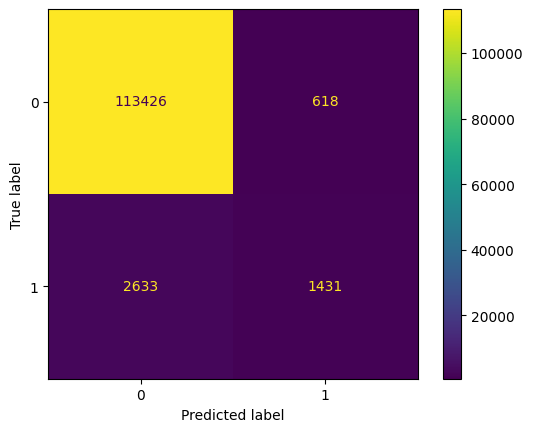

In [59]:
dspl= ConfusionMatrixDisplay(confusion_matrix(y_val, gb_preds))
dspl.plot()

In [60]:
gb_preds

array([0, 0, 0, ..., 0, 0, 0])

In [62]:
features

,C1,C10,C11,C12,C13,C14,C2,C5,C6,C8,...,id_33,M4,M5,M6,P_emaildomain,P_emaildomain_2,ProductCD,R_emaildomain,card4,card6
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,461,2,0,1,32,7,4,32,1,1
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,461,0,1,1,16,2,4,32,2,1
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,461,0,0,0,36,2,4,32,4,2
3,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,4.0,0.0,...,461,0,1,0,55,2,4,32,2,2
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,268,3,2,2,16,2,1,32,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,2.0,0.0,1.0,0.0,3.0,2.0,1.0,1.0,0.0,0.0,...,461,0,1,0,32,7,4,32,4,2
590536,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,461,0,0,1,16,2,4,32,2,2
590537,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,461,3,2,1,16,2,4,32,2,2
590538,1.0,0.0,1.0,1.0,5.0,1.0,1.0,0.0,3.0,0.0,...,461,0,0,1,2,2,4,32,2,2


In [71]:
features

,C1,C10,C11,C12,C13,C14,C2,C5,C6,C8,...,id_33,M4,M5,M6,P_emaildomain,P_emaildomain_2,ProductCD,R_emaildomain,card4,card6
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,461,2,0,1,32,7,4,32,1,1
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,461,0,1,1,16,2,4,32,2,1
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,461,0,0,0,36,2,4,32,4,2
3,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,4.0,0.0,...,461,0,1,0,55,2,4,32,2,2
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,268,3,2,2,16,2,1,32,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,2.0,0.0,1.0,0.0,3.0,2.0,1.0,1.0,0.0,0.0,...,461,0,1,0,32,7,4,32,4,2
590536,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,461,0,0,1,16,2,4,32,2,2
590537,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,461,3,2,1,16,2,4,32,2,2
590538,1.0,0.0,1.0,1.0,5.0,1.0,1.0,0.0,3.0,0.0,...,461,0,0,1,2,2,4,32,2,2


In [69]:
trans_amnt = features[["TransactionAmt"]]

In [68]:
gb_preds_all = gb_on_all.predict(features_transf)

In [70]:
trans_amnt["y_preds"] = gb_preds_all

/tmp/ipykernel_5778/3084409040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_amnt["y_preds"] = gb_preds_all


In [72]:
trans_amnt["y_true"] = target

/tmp/ipykernel_5778/1534375179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_amnt["y_true"] = target


In [73]:
trans_amnt

,TransactionAmt,y_preds,y_true
0,68.50,0,0
1,29.00,0,0
2,59.00,0,0
3,50.00,0,0
4,50.00,0,0
...,...,...,...
590535,49.00,0,0
590536,39.50,0,0
590537,30.95,0,0
590538,117.00,0,0


In [76]:
errors= trans_amnt[trans_amnt['y_preds'] != trans_amnt["y_true"]]

104663    125.000
130347     50.000
157061     21.950
170294     83.500
281804     20.845
           ...   
589992     57.950
590338    500.000
590343    500.000
590344    250.000
590445    500.000
Name: TransactionAmt, Length: 628, dtype: float64

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Distribution of TransactionAmt in case when not fraud, but model predict 1')

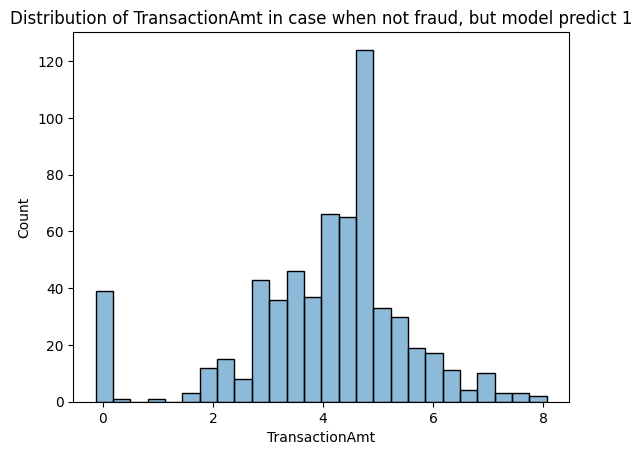

In [91]:
sns.histplot(x=np.log(errors[errors['y_preds'] == 1].TransactionAmt), alpha=0.5)
plt.title("Distribution of TransactionAmt in case when not fraud, but model predict 1")

In [78]:
errors[errors['y_preds'] == 0].TransactionAmt

,TransactionAmt,y_preds,y_true
405,90.570,0,1
1250,226.000,0,1
2041,100.000,0,1
2357,226.000,0,1
2424,428.730,0,1
...,...,...,...
590361,1224.000,0,1
590364,69.964,0,1
590368,100.000,0,1
590372,117.000,0,1


Text(0.5, 1.0, 'Distribution of TransactionAmt in case when fraud, but model predict 0')

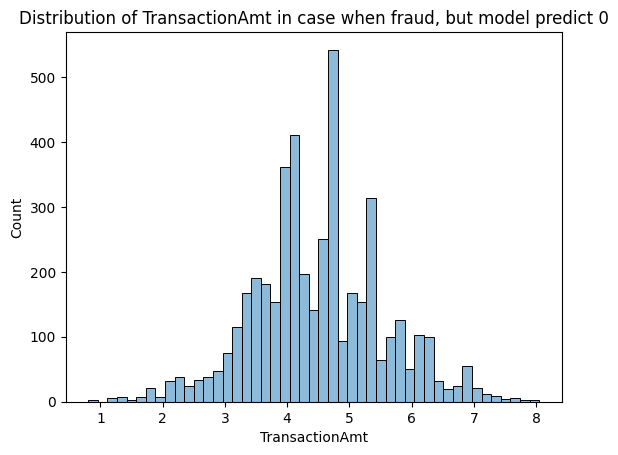

In [92]:
sns.histplot(x=np.log(errors[errors['y_preds'] == 0].TransactionAmt), alpha=0.5)
plt.title("Distribution of TransactionAmt in case when fraud, but model predict 0")


# Test


In [33]:
data_test_top_features = pd.read_csv(folder_path + "X_test_top_features.csv")

In [34]:
test_fetures = data_test_top_features.drop(['TransactionID', "isFraud"], axis=1)

In [35]:
test_fetures

,C1,C10,C11,C12,C13,C14,C2,C5,C6,C8,...,id_33,M4,M5,M6,P_emaildomain,P_emaildomain_2,ProductCD,R_emaildomain,card4,card6
0,6.0,0.0,5.0,1.0,115.0,6.0,6.0,3.0,4.0,0.0,...,461,3,2,0,16,2,4,32,4,2
1,3.0,0.0,1.0,1.0,12.0,2.0,2.0,0.0,1.0,0.0,...,461,0,2,0,2,2,4,32,4,2
2,2.0,0.0,2.0,0.0,22.0,2.0,2.0,0.0,5.0,0.0,...,461,0,0,0,19,2,4,32,4,2
3,5.0,0.0,2.0,0.0,7.0,4.0,2.0,1.0,1.0,0.0,...,461,3,2,1,16,2,4,32,4,2
4,6.0,0.0,6.0,0.0,14.0,6.0,6.0,2.0,5.0,0.0,...,461,3,2,0,16,2,4,32,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,461,2,2,2,16,2,0,16,2,2
506687,1.0,2.0,1.0,1.0,3.0,1.0,3.0,0.0,1.0,2.0,...,461,2,2,2,19,2,0,19,2,2
506688,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,461,0,0,0,19,2,4,32,4,2
506689,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,461,0,0,0,19,2,4,32,2,2


In [36]:
test_fetures_transf = column_transformer.transform(test_fetures)

In [37]:
test_fetures_transf

array([[0.        , 0.        , 0.        , ..., 0.34319656, 0.413041  ,
        0.35324827],
       [1.        , 0.        , 0.        , ..., 0.34319656, 0.413041  ,
        0.35324827],
       [1.        , 0.        , 0.        , ..., 0.34319656, 0.413041  ,
        0.35324827],
       ...,
       [1.        , 0.        , 0.        , ..., 0.34319656, 0.413041  ,
        0.35324827],
       [1.        , 0.        , 0.        , ..., 0.34319656, 0.413041  ,
        0.35324827],
       [0.        , 0.        , 1.        , ..., 0.34319656, 1.47332584,
        0.35324827]])

In [38]:
gb_proba_test = gb_on_all.predict_proba(test_fetures_transf)[:,1]

In [43]:
gb_proba_test


array([0.00174156, 0.00357599, 0.00182863, ..., 0.00663812, 0.00556337,
       0.00296379])

In [42]:
submission = data_test_top_features[["TransactionID"]]

In [44]:
submission["isFraud"] = gb_proba_test

/tmp/ipykernel_5778/2096811031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission["isFraud"] = gb_proba_test


In [47]:
submission.to_csv("submission_grad_boost.csv", index=False)